# Titanic<sub>An introduction to machine learning <sub>
[Home Page](https://www.kaggle.com/c/titanic)




<img src="https://i0.wp.com/intheboatshed.net/wp-content/uploads/2008/04/titanic_4.jpg" width="800px">

# Preliminaries

## Interesting Links

kaggle intern:
 - https://www.kaggle.com/alexisbcook/titanic-tutorial
 - https://www.kaggle.com/parulpandey/10-simple-hacks-to-speed-up-your-data-analysis#758058
 - https://www.kaggle.com/startupsci/titanic-data-science-solutions
 - https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
 - https://www.kaggle.com/pratsiuk/valueerror-unknown-label-type-continuous
 - https://www.kaggle.com/omarelgabry/a-journey-through-titanic
 
 others:
 - https://pandas-profiling.github.io/pandas-profiling/docs/


## Settings

In [1]:
# settings
# display all outputs
#from IPython.core.interactiveshell import InteractiveShell  
#InteractiveShell.ast_node_interactivity = "all"
#To revert to the original setting :
# InteractiveShell.ast_node_interactivity = "last_expr"

## Imports

In [2]:
#imports
# os 
import os

# data analysis and wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random 

# visualization and reporting
import pandas_profiling # dataframe profiling @
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import calmap


# machine learning
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# combination'
from itertools import combinations

In [3]:
# walk file structure and find input data
input_files=[]
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        path=os.path.join(dirname, filename)
        if path.endswith('submission.csv'):
            path_gs=path
        elif path.endswith('test.csv'):
            path_test=path
        elif path.endswith('train.csv'):
            path_train=path
print(path_gs,path_test,path_train)            

kaggle/input\gender_submission.csv kaggle/input\test.csv kaggle/input\train.csv


## DataFrame Creation

In [4]:
# create a dataframe for each csv file
test_df=pd.read_csv(path_test)
train_df=pd.read_csv(path_train)

combo=[test_df,train_df]

# Data Insight

## Fast report

In [5]:
# display
if False: # test report
    test_df.head()
    test_df.info()
    test_df.describe(include='all')
if True: # Train report
    train_df.head()
    train_df.info()
    #train_df.describe()
    train_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Missing values

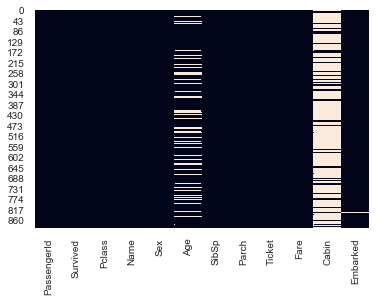

In [6]:
#heat map
sns.heatmap(train_df.isnull(), cbar=False)

## Full report

In [7]:
#profile report inline
if False: # Train Data report generation
    profile_train = train_df.profile_report(title='Titanic train data') 
    profile_train.to_file(output_file="kaggle/profile_report/Titanic_train_data.html") # save the report 
    profile_train # display inline
if False: # Test Data report generation
    profile_test = test_df.profile_report(title='Titanic test data')
    profile_test.to_file(output_file="kaggle/profile_report/Titanic_test_data.html") # save the report 
    profile_test # in order to display inline

To do: 
 1. **Name**: Get title 
 2. **Age**: 
     - Estimate missing value
     - get isChildren
 3. **Sibs** & **Parch**: Get FamillySize
 4. **Fare**: Estimate missing value
 5. **Embarked**: Estimate missing value
 6. **Tiket** and **Cabin**: erase 
 7. Idea

# Data Wrangling

## Name

### extract Title from Name

In [8]:
train_df['Surname'] = train_df.Name.str.split(',').str[0]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


In [9]:
# extract Title
for df in combo:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Surname'] = df.Name.str.split(',').str[0]
    
#display    
train_df[['Title','Survived']].groupby(['Title'],as_index=True).mean().sort_values(by='Survived',ascending=False).style.background_gradient(cmap='Reds')   

,Survived
Title,
Sir,1
Countess,1
Ms,1
Mme,1
Lady,1
Mlle,1
Mrs,0.792
Miss,0.697802
Master,0.575


### Regroup Title in Categories

In [10]:
for df in combo:
    #Rare Titles
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    #Miss, Mlle, Ms,Mme and so on
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
#display    
train_df[['Title','Survived']].groupby(['Title'],as_index=True).mean().sort_values(by='Survived',ascending=False).style.background_gradient(cmap='Reds')  

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575
Rare,0.347826
Mr,0.156673


## Sibs & Parch

In [11]:
for df in combo:
    df['FamilySize'] = df.SibSp + df.Parch + 1   
    #df.drop(['SibSp','Parch'],axis=True,inplace=True)

In [12]:
train_df[['FamilySize','Survived']].groupby('FamilySize',as_index=True).mean().sort_values('FamilySize',ascending=True).style.background_gradient(cmap='Reds')

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.2
6,0.136364
7,0.333333
8,0
11,0


In [13]:
title_mapping = {1: "alone",2: "small" ,3:"small",4: "medium",5: "large",6:"large",7:"large",8:"large",9:"large",10:"large",11: "large"}
#title_mapping = {1: "alone",2: "family" ,3:"family",4: "family",5: "family",6:"family",7:"family",8:"family",9:"family",10:"family",11: "family"}

for df in combo:
    df['FamilySize'] = df['FamilySize'].map(title_mapping)   
train_df[['FamilySize','Survived']].groupby('FamilySize',as_index=True).mean().sort_values('Survived',ascending=True).style.background_gradient(cmap='Reds')

,Survived
FamilySize,
large,0.16129
alone,0.303538
small,0.562738
medium,0.724138


## Fare

In [14]:
test_df.loc[test_df.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,FamilySize
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,Storey,alone


In [15]:
median_train=train_df.loc[(train_df.Pclass==3)&
             (train_df.Sex=='male')&
             (train_df.Embarked=='S')]['Fare'].median()
median_train

8.05

In [16]:
# replace missing value by median considering known information
test_df.loc[test_df.Fare.isna(),'Fare']=median_train

In [17]:
#check for more missing value
test_df.loc[test_df.Fare.isna()]['Fare'].sum()

0.0

In [18]:
#convert float to int
for df in combo:
    df['Fare'] = df['Fare'].astype(int)

## PClass

In [19]:
for df in combo:
    df['Pclass'] = df['Pclass'].astype(str)
    
train_df[['Pclass','Survived']].groupby('Pclass',as_index=True).mean().sort_values('Survived',ascending=True).style.background_gradient(cmap='Reds')

,Survived
Pclass,
3,0.242363
2,0.472826
1,0.62963


## Embarked

### Missing Value

In [20]:
train_df.loc[train_df.Embarked.isna()]
test_df.loc[test_df.Embarked.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,FamilySize


**Comment:**
 - The First class Ladies share a cabin and a Tiket but are not from the same family, probably friends allthough they have a significant age difference
 - Let's check the Fare statistic

In [21]:
train_df[['Pclass','Fare','Embarked']].dropna().groupby(['Pclass','Embarked'],as_index=True).describe()

Fare                                                        
                 count        mean        std   min   25%   50%     75%    max
Pclass Embarked                                                               
1      C          85.0  104.235294  99.124579  26.0  49.0  78.0  110.00  512.0
       Q           2.0   90.000000   0.000000  90.0  90.0  90.0   90.00   90.0
       S         127.0   69.992126  58.802939   0.0  29.0  52.0   83.00  263.0
2      C          17.0   25.000000  11.407235  12.0  13.0  24.0   37.00   41.0
       Q           3.0   12.000000   0.000000  12.0  12.0  12.0   12.00   12.0
       S         164.0   20.140244  13.626430   0.0  13.0  13.0   26.00   73.0
3      C          66.0   10.833333   4.824882   4.0   7.0   7.0   14.00   22.0
       Q          72.0   10.555556   6.927977   6.0   7.0   7.0    9.75   29.0
       S         353.0   14.144476  13.266031   0.0   7.0   8.0   16.00   69.0

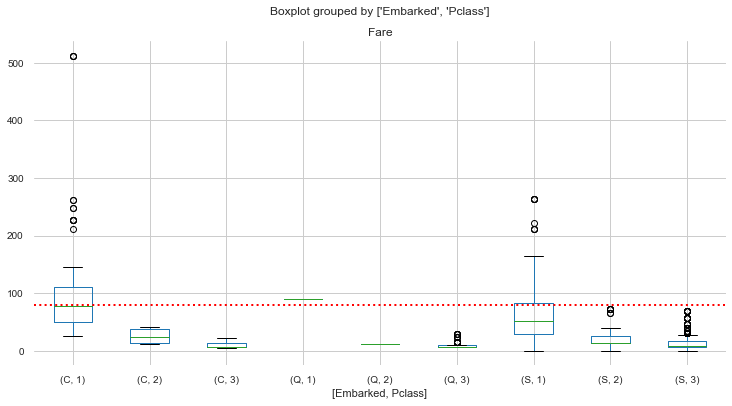

In [22]:
Fare_price=train_df.loc[train_df.PassengerId==62,'Fare'].values[0]
ax=train_df[['Pclass','Fare','Embarked']].dropna().boxplot(column='Fare',by=['Embarked','Pclass'],figsize=(12,6))
ax.axhline(y=Fare_price, color="red",linewidth=2,linestyle='dotted')

They would likly have Embarked in **Cherbourg** since:
- the median of C is about **80**, And have a significant 1st class embarkation
- Q have only embarked two 1st class its median is  90
- S 1st Class median is arround 50

In [23]:
#fill missing 
train_df.loc[train_df.Embarked.isna(),'Embarked']='C'

In [24]:
#check
train_df.loc[train_df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,FamilySize


## Age

### Age with distribution

In [25]:
for df in combo:
    # get average, std, and number of NaN values in train_df
    average_age_df   = df["Age"].mean()
    std_age_df       = df["Age"].std()
    count_nan_age_df = df["Age"].isnull().sum()

    # generate random numbers between (mean - std) & (mean + std)
    rand = np.random.randint(average_age_df - std_age_df, average_age_df + std_age_df, size = count_nan_age_df)

    # fill NaN values in Age column with random values generated
    df.loc[df.Age.isnull(),'Age'] = rand

    # convert from float to int
    df['Age'] = df['Age'].astype(int)


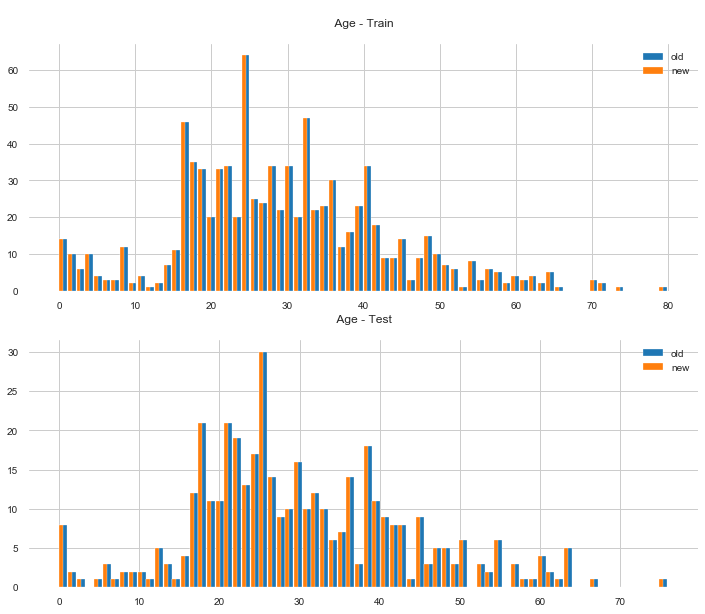

In [26]:
#plot old vs new overlap grid 2,1
if True:
    fig, axs = plt.subplots(2, 1,figsize=(12,10))
    axs[0].set_title('\n Age - Train \n')
    axs[1].set_title('\n Age - Test \n')


    # plot Old Age Values
    train_df['Age'].dropna().astype(int).hist(bins=70,width=1, ax=axs[0],label="old")
    test_df['Age'].dropna().astype(int).hist(bins=70,width=1, ax=axs[1],label="old")

    # plot new Age Values
    train_df['Age'].hist(bins=70,width=0.5, ax=axs[0],label="new")
    test_df['Age'].hist(bins=70,width=0.5, ax=axs[1],label="new")
    axs[1].legend()
    axs[0].legend()

In [27]:
#plot old vs new grid 2x2
if False:
    fig, axs = plt.subplots(2, 2,figsize=(15,8))
    axs[0, 0].set_title(' Age - Train')
    axs[0, 1].set_title('New Age values - Train')
    axs[1, 0].set_title(' Age - Test')
    axs[1, 1].set_title('New Age values - Test')

    # plot Old Age Values
    train_df['Age'].dropna().astype(int).hist(bins=50, ax=axs[0, 0])
    test_df['Age'].dropna().astype(int).hist(bins=50, ax=axs[1, 0])

    # plot new Age Values
    train_df['Age'].hist(bins=50, ax=axs[0, 1])
    test_df['Age'].hist(bins=50, ax=axs[1, 1])
    #train_df['Age'].hist(bins=50, ax=axs[0, 0])
    #test_df['Age'].hist(bins=50, ax=axs[1, 0])

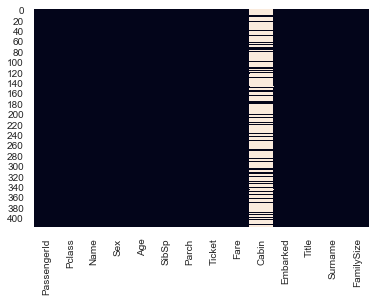

In [28]:
#check if anymore missing values
sns.heatmap(test_df.isnull(), cbar=False)

## New Ideas

### Child

In [29]:
Age_adulthood=16
for df in combo:
    df['isChild'] = 'yes'
    df.loc[df['Age']>=Age_adulthood,'isChild']='no'

In [30]:
train_df[['isChild', 'Survived']].groupby(['isChild'], as_index=True).mean().sort_values(by='Survived',ascending=False).style.background_gradient(cmap='Reds')

,Survived
isChild,
yes,0.58427
no,0.361596


### Motherhood

In [31]:
#Motherhood
train_df.loc[(train_df.Sex=='male')&
             (train_df.Parch!=0)&
             (train_df.Title=='Mr')].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,FamilySize,isChild
13,14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31,NaN,S,Andersson,Mr,large,no
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19,3,2,19950,263,C23 C25 C27,S,Fortune,Mr,large,no
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65,0,1,113509,61,B30,C,Ostby,Mr,small,no
86,87,0,3,"Ford, Mr. William Neal",male,16,1,3,W./C. 6608,34,NaN,S,Ford,Mr,large,no
93,94,0,3,"Dean, Mr. Bertram Frank",male,26,1,2,C.A. 2315,20,NaN,S,Dean,Mr,medium,no


In [32]:
for df in combo:
    df['isParent']='no'
    df.loc[(df.Sex=='female') & (df.Parch!=0) & (df.Title=='Mrs'),'isParent']='mother'
    df.loc[(df.Sex=='male') & (df.Parch!=0) & (df.Title=='Mr'),'isParent']='father'

In [33]:
# for categorical data only
#pd.crosstab(train_df.isMother, train_df.Survived)

In [34]:
train_df[['isParent', 'Survived']].groupby(['isParent'], as_index=True).mean().sort_values(by='Survived',ascending=False).style.background_gradient(cmap='Reds')

,Survived
isParent,
mother,0.714286
no,0.376756
father,0.134615


### Person

In [35]:
for df in combo:
    df.loc[:,'Person']=df.loc[:,'Sex']
    df.loc[df.isChild=='yes','Person']='Child'
    #df.loc[df.isParent=='mother','Person']='Mother'
    #df.loc[df.isParent=='father','Person']='father'

In [36]:
train_df[['Person', 'Survived']].groupby(['Person'], as_index=True).mean().sort_values(by='Survived',ascending=False).style.background_gradient(cmap='Reds')

,Survived
Person,
female,0.753731
Child,0.58427
male,0.164794


## Cleaning

### Ticket and Cabin

**Ticket** and **Cabin** Have So many uncertainties that they can not be of anymore Help

In [37]:
for df in combo:
    df.drop(['Ticket','Cabin'],axis=1,inplace=True)

**Name** is no longer usefull

In [38]:
for df in combo:

    df.drop(['Name'],axis=1,inplace=True)

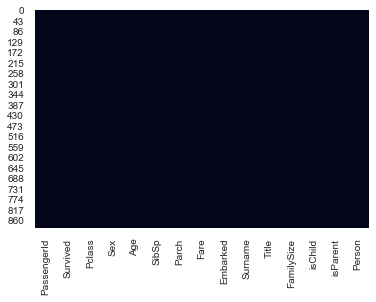

In [39]:
#check
sns.heatmap(train_df.isnull(), cbar=False)

#sns.heatmap(test_df.isnull(), cbar=False)

# Machine learning

## all possible Features

In [41]:
# all possible feature
Possible_features=train_df.columns.to_list()
Possible_features.remove('PassengerId')
Possible_features.remove('Survived')
print(Possible_features)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Surname', 'Title', 'FamilySize', 'isChild', 'isParent', 'Person']


## Remove manually Features

In [42]:
# remove feature
# orginal
#Possible_features.remove('Age')
#Possible_features.remove('Fare')
#Possible_features.remove('Embarked')
#Possible_features.remove('Sex')
#Possible_features.remove('SibSp')
#Possible_features.remove('Parch')

# new
#Possible_features.remove('FamilySize')
#Possible_features.remove('Title')
Possible_features.remove('Surname')
Possible_features.remove('isParent')
Possible_features.remove('isChild')
#Possible_features.remove('Person')

features=Possible_features
print(features)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'Person']


## determine the best feature set with score

### All possible combinason of Possible_features

In [43]:
feature_combi = sum([list(map(list, combinations(Possible_features, i))) for i in range(len(Possible_features) + 1)], [])

In [44]:
len(feature_combi)

1024

### results data frame

In [45]:
ml_results=pd.DataFrame(columns=['feature_set','Ml_score'])

In [46]:
i=0
for feature_set in feature_combi:
    if len(feature_set)>=2:
        
        #prepare data
        Y_train  = train_df["Survived"]
        X_train  = pd.get_dummies(train_df[feature_set])
        X_test = pd.get_dummies(test_df[feature_set])
        
        #compute model
        model = RandomForestClassifier(n_estimators=100)
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        #Determine Score 
        score=round(model.score(X_train, Y_train)*100,2)
        
        #update ml result
        ml_results.loc[i]=feature_set,score
        i+=1

### best score

In [47]:
best_score=ml_results.loc[ml_results.Ml_score==ml_results.Ml_score.max()]
best_score

,feature_set,Ml_score
707,"[Pclass, Age, SibSp, Fare, Embarked, Title]",97.19
727,"[Pclass, Age, Fare, Embarked, Title, FamilySize]",97.19
847,"[Pclass, Sex, Age, SibSp, Fare, Embarked, Title]",97.19
893,"[Pclass, Age, SibSp, Parch, Fare, Embarked, Ti...",97.19
903,"[Pclass, Age, SibSp, Fare, Embarked, Title, Fa...",97.19
904,"[Pclass, Age, SibSp, Fare, Embarked, Title, Pe...",97.19
908,"[Pclass, Age, Parch, Fare, Embarked, Title, Fa...",97.19
913,"[Pclass, Age, Fare, Embarked, Title, FamilySiz...",97.19
957,"[Pclass, Sex, Age, SibSp, Parch, Fare, Embarke...",97.19
967,"[Pclass, Sex, Age, SibSp, Fare, Embarked, Titl...",97.19


### best feature set

#### smallest

In [52]:
smallest_feature_Set = best_score.loc[ best_score.index.min(),'feature_set']
smallest_feature_Set

['Pclass', 'Age', 'SibSp', 'Fare', 'Embarked', 'Title']

,importance
feature,
Title,32.7478
Age,28.3944
Fare,20.2223
Pclass,10.0709
SibSp,5.06241
Embarked,3.50214


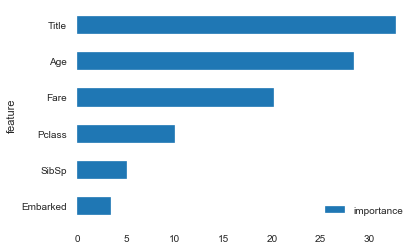

In [53]:
Y_train  = train_df["Survived"]
X_train  = pd.get_dummies(train_df[smallest_feature_Set])
X_test = pd.get_dummies(test_df[smallest_feature_Set])

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train)
predictions_small_set = model.predict(X_test)

# importance
variable_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_*100})
variable_importance['feature']=variable_importance['feature'].str.split("_", n = 1, expand = True) 
variable_importance=variable_importance.groupby('feature',as_index=True).sum().sort_values(by='importance', ascending=True)
variable_importance.plot.barh()
variable_importance.sort_values(by='importance', ascending=False).style.background_gradient(cmap='Greens')

#### biggest

In [54]:
biggest_feature_Set = best_score.loc[ best_score.index.max(),'feature_set']
biggest_feature_Set

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Title',
 'FamilySize',
 'Person']

,importance
feature,
Age,25.0009
Fare,16.4374
Sex,15.0481
Person,10.866
Title,9.79783
Pclass,9.2234
FamilySize,5.24237
Embarked,3.28363
SibSp,2.85589


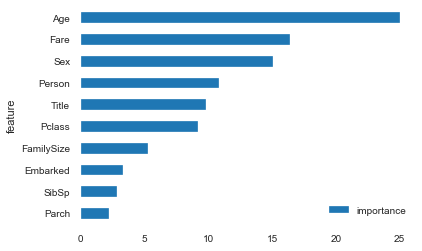

In [55]:
Y_train  = train_df["Survived"]
X_train  = pd.get_dummies(train_df[biggest_feature_Set])
X_test = pd.get_dummies(test_df[biggest_feature_Set])

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, Y_train)
predictions_big_set = model.predict(X_test)

# importance
variable_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_*100})
variable_importance['feature']=variable_importance['feature'].str.split("_", n = 1, expand = True) 
variable_importance=variable_importance.groupby('feature',as_index=True).sum().sort_values(by='importance', ascending=True)
variable_importance.plot.barh()
variable_importance.sort_values(by='importance', ascending=False).style.background_gradient(cmap='Greens')

##  determine the Ml model 

- for big and small best feature set
- according to model score

# Submit

In [56]:
output_small_set = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions_small_set})
output_big_set = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions_big_set})
#output.set_index('PassengerId',inplace=True)
#output.head()

In [57]:
output_small_set.to_csv('kaggle/output/small_set_submission.csv', index=False)
output_big_set.to_csv('kaggle/output/big_set_submission.csv', index=False)
#output.to_csv('my_ml_submission.csv', index=False)
